[GitHub link](https://github.com/AidMMcMillan/AidMMcMillan.github.io/blob/main/posts/blog3)

In this blog post I will be attempting to classify penguins by finding 3 features that can be used most acurarately catagorize the penguins into 3 species: **Chinstrap**, **Gentoo** and **Adélie**. The Palmer Penguins data set we are using was collected by Dr. Kristen Gorman and the Palmer Station, Antarctica LTER, a member of the Long Term Ecological Research Network.

# Loading and Preparing Data

In order to start working with the data, I first have to prepare it so it can be interpreted by the scikit-learn methods. The fist step is to access the data using the pandas library:

In [4]:
import pandas as pd

train_url = "https://raw.githubusercontent.com/middlebury-csci-0451/CSCI-0451/main/data/palmer-penguins/train.csv"
train = pd.read_csv(train_url)

This is how that the first few rows of that data look:

In [5]:
train.head(3)

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0708,27,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N46A1,Yes,11/29/07,44.5,14.3,216.0,4100.0,NaN,7.96621,-25.69327,NaN
1,PAL0708,22,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N41A2,Yes,11/27/07,45.1,14.5,215.0,5000.0,FEMALE,7.63220,-25.46569,NaN
2,PAL0910,124,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N67A2,Yes,11/16/09,41.4,18.5,202.0,3875.0,MALE,9.59462,-25.42621,NaN


Now I have to prepare the qualitative featurs in the data set using ```pd.get_dummies``` for ```Sex``` and ```Island``` and a ```LabelEncoder``` for ```Species```. I also removed all irrelevant features:

In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train["Species"])

def prepare_data(df):
  df = df.drop(["studyName", "Sample Number", "Individual ID", "Date Egg", "Comments", "Region"], axis = 1)
  df = df[df["Sex"] != "."]
  df = df.dropna()
  y = le.transform(df["Species"])
  df = df.drop(["Species"], axis = 1)
  df = pd.get_dummies(df)
  return df, y

X_train, y_train = prepare_data(train)

Now if we look at the data we can see that in much better condition to be processed:

In [7]:
X_train.head(3)

,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Delta 15 N (o/oo),Delta 13 C (o/oo),Island_Biscoe,Island_Dream,Island_Torgersen,"Stage_Adult, 1 Egg Stage",Clutch Completion_No,Clutch Completion_Yes,Sex_FEMALE,Sex_MALE
1,45.1,14.5,215.0,5000.0,7.63220,-25.46569,1,0,0,1,0,1,1,0
2,41.4,18.5,202.0,3875.0,9.59462,-25.42621,0,0,1,1,0,1,0,1
3,39.0,18.7,185.0,3650.0,9.22033,-26.03442,0,1,0,1,0,1,0,1


# Displaying and Discussing Data

Before choosing my features, I am going to display and discuss a few of the features in the data set in order to highlight some patterns in the data. First I will use the ```seaborn``` library to display the realationsip between **flipper length** and **body mass**.

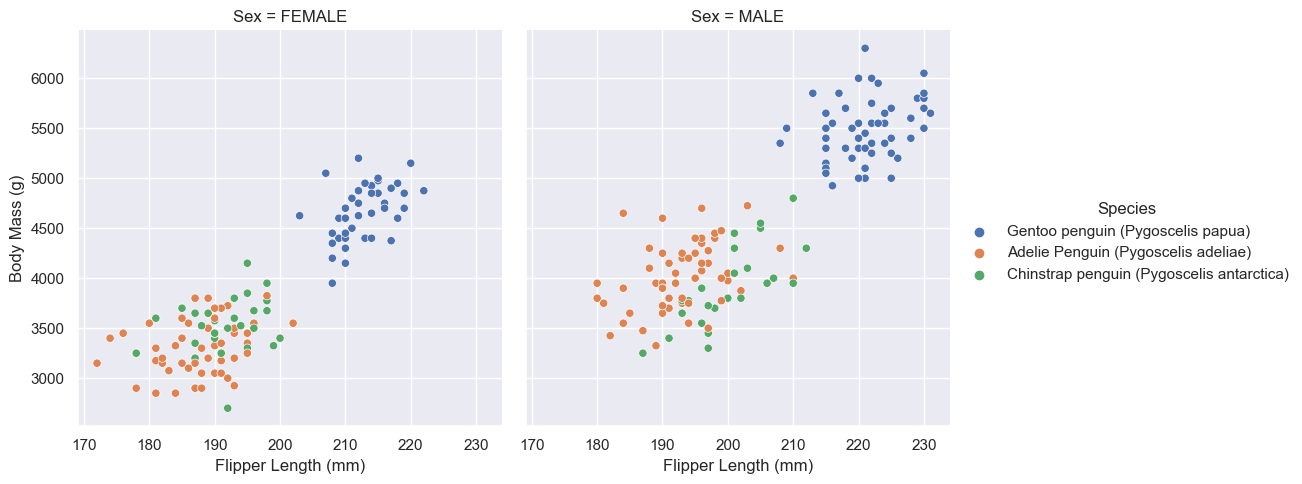

In [8]:
import seaborn as sns

# Apply the default theme
sns.set_theme()

# Remove penguin who's sex was not identified
train = train[train["Sex"] != "."]

# Create a visualization
sns.relplot(
    data=train,
    x="Flipper Length (mm)", y="Body Mass (g)", col="Sex",
    hue="Species"
)

From this data we can observe a few interesting patterns. The first is that Gentoo penguins are can be easily identified by their body mass and flipper length. The data clearly shows that Gentoo penguins are heavier penguins with larger flippers. Not only are they easily identifiable, the two data sets are linearly seperable (Gento and not Gentoo), given we know the sex of the penguin. 

We can see also see that Adelie and Chinstrap penguins have very similar body masses and flipper lengths and are therefore not easily identifiable from eachother using those two features. 

This would mean that in our model, these two factors (body mass and flipper length), although good at identifying Gentoo penguins from non Gentoo penguins, would probably not be good at identifying Adelie from Chinstrap.

One other interesting obsrvation we can draw from this graph is that the male penguins tend to be larger then the female penguins.
\
\
Now I will take a look at the amount of each species of Penguin on each island.

In [9]:
train.groupby(["Island", "Species"])[["Species"]].count().unstack(fill_value=0).stack()

Species
Island    Species                                           
Biscoe    Adelie Penguin (Pygoscelis adeliae)             35
          Chinstrap penguin (Pygoscelis antarctica)        0
          Gentoo penguin (Pygoscelis papua)              100
Dream     Adelie Penguin (Pygoscelis adeliae)             41
          Chinstrap penguin (Pygoscelis antarctica)       56
          Gentoo penguin (Pygoscelis papua)                0
Torgersen Adelie Penguin (Pygoscelis adeliae)             42
          Chinstrap penguin (Pygoscelis antarctica)        0
          Gentoo penguin (Pygoscelis papua)                0

From this graph we can see that each species is found on each island in very different amounts. If a penguin is from Biscoe island, it is very unlikely it will be Chinstrap (the data is just a sample so there may be some on the island). Likewise, it would be unlikely to find Gentoo on Dream Island and a Chinstrap or Gentoo on Torgersen island. 

This also shows that  more penguins were surveyed from Biscoe than Dream and many more were surveyed from Dream than Torgersen. This may lead to our clasification algorithm better classifying penguins from Biscoe when compared to those form Dream and Torgersen.

# Choosing Features

In order to choose the three features that could best classify by data, I used ```sklearn``` to implement cross validation using linear regression. I first found all possible combinations of one qualitative column and two quantitative columns and then calculated the scores of each combination. Lastly I found the combination with the highest score.

In [10]:
from itertools import combinations
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

all_qual_cols = ["Clutch Completion_No", "Clutch Completion_Yes", "Sex_FEMALE", "Sex_MALE", "Island_Biscoe", "Island_Dream", "Island_Torgersen"]
all_quant_cols = ["Culmen Length (mm)", "Culmen Depth (mm)", "Flipper Length (mm)", "Body Mass (g)"]

scored_cols = []
LR = LogisticRegression(max_iter = 750)

# Find all posible combinations of one qual. column and two quant. columns
for qual in all_qual_cols: 
    qual_cols = [col for col in X_train.columns if qual in col ]
    for pair in combinations(all_quant_cols, 2):
        cols = qual_cols + list(pair)
        # Falculate each combination's scores using linear regression and cross validation
        scores = cross_val_score(LR, X_train[cols], y_train, cv=5)
        scored_cols.append([cols, scores.mean()])

best_score = 0

# Find combination w/ highest score
for row in scored_cols:
    if row[1] > best_score:
        best_cols = row[0]
        best_score = row[1]
    
print(best_cols, best_score)

['Island_Dream', 'Culmen Length (mm)', 'Culmen Depth (mm)'] 0.988310708898944


As we can see the ```Island_Dream```, ```Culmen Length (mm)```, and ```Culmen Depth (mm)``` columns seem to do the best job at classifying the data. The image below by @allison_horst shows what the culmen length and depth refer to.

![Culmen length and depth refers to the length and height of the penguin's beak](culmen_depth.png){width=50%}

# Training and Ploting Data (Logistic Regression)

Finally, I will train the logistic regression model on the data. In order to do so, I created a new column called ```Island_Dream_No``` which is the opposite of the ```Island_Dream``` column. That way I was able desplay all of the data using the ```plot_regions``` function defined [here](https://github.com/AidMMcMillan/AidMMcMillan.github.io/blob/main/posts/blog3/plot_regions.py).

1.0


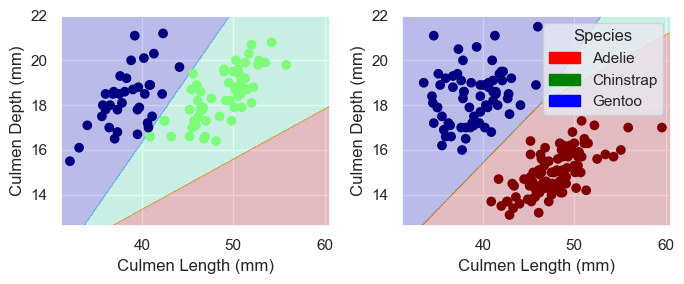

In [37]:
from plot_regions import plot_regions

import warnings
warnings.filterwarnings("ignore")

# Create column that is the opposite of "Island_Dream" in order to plot regions
not_Island_Dream = X_train[["Island_Biscoe", "Island_Torgersen"]].sum(axis=1)
X_train["Island_Dream_No"] = not_Island_Dream

cols = ["Culmen Length (mm)", "Culmen Depth (mm)", "Island_Dream", "Island_Dream_No"]

LR = LogisticRegression()
LR.fit(X_train[cols], y_train)
score = LR.score(X_train[cols], y_train)

warnings.filterwarnings("default", category=FutureWarning)

print(score)

plot_regions(LR, X_train[cols], y_train)

Because the data is linearly seperable, we are able to reach a score of 1.0. It is also important to note that the data does not seem to be overfit. I think for this reason, linear regression without feature mapping is probably a good choice for a model as it does not "hug" the data. Furthermore, the data seems to be shaped in blobs that can be roughly seperated by linear decision boundries.

# Test Data

Finaly, I am going to test to the model on our testing data. I loadd and prepared the data similarly to the training data, ran it thorugh the logistic regression model, then showed the score and plots of this data.

0.9852941176470589


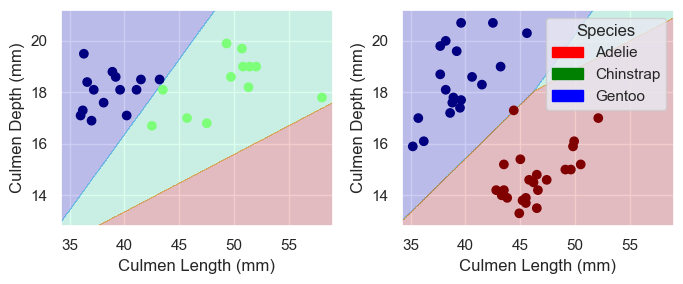

In [38]:
test_url = "https://raw.githubusercontent.com/middlebury-csci-0451/CSCI-0451/main/data/palmer-penguins/test.csv"
test = pd.read_csv(test_url)

X_test, y_test = prepare_data(test)

not_Island_Dream = X_test[["Island_Biscoe", "Island_Torgersen"]].sum(axis=1)
X_test["Island_Dream_No"] = not_Island_Dream

score = LR.score(X_test[cols], y_test)
print(score)

plot_regions(LR, X_test[cols], y_test)

With a score of roughly 98%, this model is very acurate. We can see that the model likely did not overfit to the training data beause it only incorrectly predicted one penguin that was just above the decesion line for it's correct species.